---
<img src="../assets/grt_logo.png" style="float: left; margin: 20px; height: 55px">

# Garton Research & Trading

_May 2019_

---

## Breast Cancer Classification Study

---

**Context:** The purpose of this study is to use classification modeling techniques for breast cancer diagnosis. This is primarily a learning exercise for me in exploring machine learning concepts. For this study I used the [Wisconsin Breast Cancer Classification](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29) dataset from the UCI Repository.

In this final notebook, I turn my attention to modeling. I'll build and evaluate a few different classifiers to diagnose breast cancer cells as either malignant or benign.

_Author: Matthew Garton_

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

In [2]:
# load in the (cleaned) dataset
cancer = pd.read_csv('../data/breast-cancer-cleaned.csv', index_col=0)

In [3]:
# These are some reusable functions that I wrote previously and like to use for any classification problem:
# They give me to get a nice printout of results which is generalizable for any scikit-learn model

def plot_roc_auc(fpr, tpr, roc_auc):
    '''Plots the ROC-AUC for a given model and test data'''

    # Create a plot of the ROC-AUC Curve
    plt.figure(figsize = (10,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show()
    
def get_classification_results(model, model_name, X_train, X_test, y_train, y_test):
    '''For a classification model, predict y values and calculate Accuracy, return a confustion matrix,
    calculate TP, TN, FP, FN, and other metrics on both training and testing data'''
    
    # Training Scores
    y_predict_tr = model.predict(X_train)
    accuracy_train = model.score(X_train, y_train)
    
    # Testing Scores
    y_predict = model.predict(X_test)
    accuracy_test = model.score(X_test, y_test)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_predict)
    
    # ROC-AUC
    probas = model.predict_proba(X_test)
    preds = probas[:,1]
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Create dictionary to store model results
    model_dict = {
        'Model': model_name,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        'Precision': precision,
        'Recall': recall,
        'F_1 Score': fbeta_score,
        'Support': support,
        'ROC-AUC': roc_auc
    }
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_predict) 

    print(classification_report(y_test, y_predict), '\n')
    print('ROC-AUC: {}'.format(roc_auc))
    
    plot_roc_auc(fpr, tpr, roc_auc)
    
    return model_dict, cm

def print_confusion_matrix(cm):
    """Given a confusion matrix, produce a table showing the results"""
    cm_df = pd.DataFrame(data=cm, columns=['Predicted Benign', 'Predicted Malignant'],
                         index=['Actual Benign', 'Actual Malignant'])
    return cm_df

## Data Preparation

The following cells, which will be repeated below for the other models, are standard first steps for any modeling problem.

1. First, split data into matrix **X** of predictors and vector **y** target.
2. Train test split (crucial to do this before conducting analysis - in fact, best practice would have been to do this _before_ even doing any EDA/Visualizations)
3. (If necessary) Standard scale **X** variables.

In [4]:
# Split data into X and y
X = cancer.drop(columns='diagnosis')
y = cancer['diagnosis']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [5]:
## (Optional) - run this cell to Standard Scale your features
## Necessary for implementing Ridge or Lasso regularization, 
## but not required for Ordinary Least Squares Regression

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Logistic Regression

The first model I will build is a logistic regression. 

**Advantages**:
1. Linear models are easier to understand and interpret, so when it is important to be able to understand the model, or explain it to a non-technical audience, they can often be preferable.
2. Coefficients provide a direct description of how each predictor relates to the target.
3. Being a simpler model, regression is less prone to overfitting than some more complex classifiers.

**Disadvantages**:
1. Linear models are generally simple and inflexible. As the name suggests, they assume a linear relationship between the X and y variables. Therefore, they tend to be high-bias and can fail to detect meaningful non-linear relationships.
2. Regression models rely on relatively strict assumptions of the underlying variables, their relationships to each other, and of the distribution of errors. In addition to the linearity assumption, regression models assume no multicollinearity between independent variables, and normality of errors.

In [6]:
# Instantiate model
logreg = LogisticRegression()

# Fit model
logreg.fit(X_train, y_train)

# View parameters
print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

# Evaluate model
print(f'\nTrain Score: {logreg.score(X_train, y_train)}')
print(f'Test Score: {logreg.score(X_test, y_test)}')

Logreg intercept: [-0.38873376]
Logreg coef(s): [[-1.97578297e+00 -1.81199439e-01  7.74744683e-02  1.10959452e-03
   1.37433091e-01  3.85920754e-01  5.70695440e-01  3.05171275e-01
   1.78375820e-01  2.54480144e-02  2.13907869e-02 -1.60283379e+00
   2.03359352e-01  9.19141604e-02  1.37503383e-02  3.66132620e-03
   4.95654553e-02  3.67975905e-02  4.48122079e-02 -5.49586079e-03
  -1.22691467e+00  4.36847299e-01  8.05824397e-02  2.53076956e-02
   2.20599692e-01  1.03216884e+00  1.36509503e+00  5.44794905e-01
   6.78908798e-01  9.19582064e-02]]

Train Score: 0.9582417582417583
Test Score: 0.9385964912280702


**Controlling for overfitting**

While the above example actually performed quite well and does not appear to suffer from overfitting, there are a few common strategies to control overfitting for logistic regression models. Among the most common and easiest to implement are Ridge and Lasso regularization. These are two ways of adding a 'penalty' to the loss function for adding additional variables. Lasso will try to filter out less useful predictors entirely, while Ridge shrinks coefficients without getting rid of them entirely. Below, I show one example of using a gridsearch to test out different ridge and lasso penalties.

A couple of other approaches to controlling for overfitting include dimensionality reduction (for example, by using Principal Component Analysis to extract the most meaningful variations in the data) or a less systematic approach of choosing which variables (and polynomials) to include or drop out.

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        72
          1       0.98      0.95      0.96        42

avg / total       0.97      0.97      0.97       114
 

ROC-AUC: 0.9963624338624338


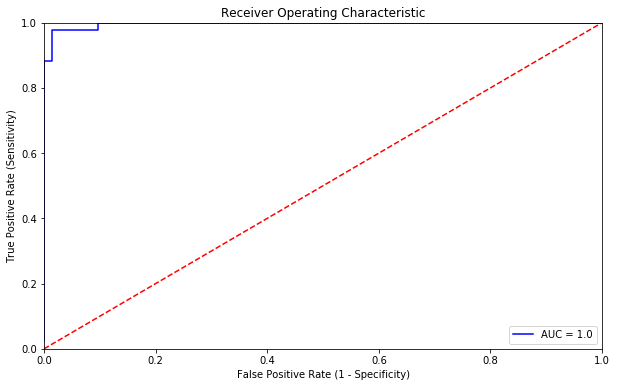

,Predicted Benign,Predicted Malignant
Actual Benign,71,1
Actual Malignant,2,40


In [7]:
# Logistic Regression Model

# Set up gridsearch
grid_params = {
    'penalty':['l1','l2'], # test out both ridge and lasso regularization
    'C':[0.01, 0.1, 0.5, 1] # try a range of 'penalties' - smaller values of C means more regularization
}

lr = LogisticRegression()

gs = GridSearchCV(lr, grid_params, scoring='roc_auc', n_jobs=-1)
model = gs.fit(X_train_scaled, y_train)

# Run and evaluate model
model_dict, cm = get_classification_results(model, 'Logistic Regression (basic)',
                                            X_train_scaled, X_test_scaled,
                                            y_train, y_test)

print_confusion_matrix(cm)



In [8]:
# When using gridsearch, it's always a good idea to check which model parameters 'won'
print(model.best_params_)

# In this case it turns out that the best model had no regularization

{'C': 1, 'penalty': 'l1'}


## Model Evaluation

**Baseline Accuracy:** Recall that earlier analysis showed the balance between benign and malignant to be 38% to 62%, respectively, implying a baseline accuracy of 62% as a worst-case-scenario.

**Labeling:** For this problem, a positive case (value of 1) is a malignant diagnosis, and a negative case (value of 0) is a benign one.

I used a few different criteria to evaluate my model. The default and a good starting point for most classification problems is **accuracy**, or the percentage of correct predictions. On this metric, the basic logistic regression model performed quite well and and exhibitied low-bias (similarly high accuracy on training and testing data. Other metrics used, were **precision** (or positive predictive value - which indicates the percent of positive predictions which were correct), **recall** (which measures the percentage of positive cases that were correctly identified), **f1-score** (which takes into account both false positives and false negatives) and **ROC-AUC** (area under the curve of the receiver-operator-characteristic which we want to maximize and shows the tradeoff between True Positives and False Positives). On all of these metrics, the model performs extremely well, with values very close to 1.0.

## Feature Importance

While the coefficients in a logistic regression provide a useful interpretation (effect of a one unit change in $x_i$ on the log-odds of $y$), there is actually not a straightforward way to _rank_ the coefficients in terms of importance. However, there are a couple of methods I'll use to get a relative understanding of the importance of each. First, ranking them by coefficient should give a pretty good idea of which variables are most important (I'll use the second model, because the features have already been standardized, so the variable _scale_ won't be confused with variable _importance_.

In [9]:
coefs = pd.DataFrame(data=model.best_estimator_.coef_.T, index=X.columns, columns=['Coefficient'])
print(coefs.sort_values(by='Coefficient', ascending=False).head(15))
print('')
print(coefs.sort_values(by='Coefficient', ascending=True).head(15))

                            Coefficient
area_sd_error                  2.656839
concave_points_worst           2.104388
concave_points_mean            2.073949
perimeter_sd_error             1.917372
concavity_worst                1.618461
symmetry_worst                 1.093838
fractal_dimension_sd_error     0.658402
smoothness_worst               0.314263
fractal_dimension_mean         0.280369
symmetry_mean                  0.260024
compactness_worst              0.222219
radius_mean                    0.000000
compactness_sd_error           0.000000
symmetry_sd_error              0.000000
concave_points_sd_error        0.000000

                         Coefficient
compactness_mean           -0.994067
area_worst                 -0.689397
concavity_sd_error         -0.278569
radius_mean                 0.000000
symmetry_sd_error           0.000000
concave_points_sd_error     0.000000
concavity_mean              0.000000
compactness_sd_error        0.000000
smoothness_sd_error       

In theory, the above tells me which variables have the greatest (positive and negative) influence on the probability of a malignant diagnosis. However, there are a number of problems with this approach. Most importantly, the coefficients only give an estimate of the relationship between $x_i$ and $y$ _all else equal_, which is not what we tend to see in the real world. Additionally, the size of the coefficient tells me nothing about the statistical significance of the relationship. 

Below, I implement a scikit-learn feature selection method, `f_classif()` which produces F values of features for a classification problem, based on univariate analyses of each feature. To clarify, what I'm going here is performing an F-test of each variable _individually_ to determine whether or not it's coefficient is meaningful as a predictor of y. Again, the ranking produced below is not a rigorous ordering of variables by importance per se, but it is another way to view which features are important - those with low p-values and high f scores are likely important predictors, etc.. 

In [10]:
from sklearn.feature_selection import f_classif

f_scores = f_classif(X_train, y_train)

coefs = pd.DataFrame(data={'f_score (univariate)': f_scores[0],
                           'p_value': f_scores[1]},
                           index=X.columns)

coefs.sort_values(by='f_score (univariate)', ascending=False).head(10)

,f_score (univariate),p_value
fractal_dimension_mean,733.724933,8.778594e-97
concave_points_sd_error,717.246487,2.093046e-95
concavity_worst,692.861395,2.483688e-93
perimeter_sd_error,684.526845,1.300875e-92
radius_worst,548.413236,4.687521e-80
concave_points_worst,522.188947,1.932387e-77
radius_mean,511.274848,2.485053e-76
texture_mean,444.857518,2.691158e-69
perimeter_mean,397.592082,5.781926e-64
symmetry_worst,319.507776,1.820808e-54


***

To reduce scrolling back and forth and to minimize errors, I am repeating the data preparation steps below before proceeding to a new model.

In [11]:
# Split data into X and y
X = cancer.drop(columns='diagnosis')
y = cancer['diagnosis']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

## Decision Tree Classifier

The second model I'd like to try is the Decision Tree Classifier. 

**Advantages**

1. This model is extremely intuitive and easy for even a non-technical audience to understand.
2. Decision Trees are much more flexible than Regression models as they do not rely on a linear relationship and make far fewer assumptions about the underlying data.
3. As shown below, decision trees provide a very clear-cut way to rank the usefulness of features.

**Disadvantages**

1. The most notable downside of Decision Trees is that they are highly prone to overfitting, due to their relative flexibility.
2. The specific interpretation of each variable's effect on y is less clear than for a logistic regression.

In [12]:
# Instantiate model
dt = DecisionTreeClassifier()

# Fit model
dt.fit(X_train, y_train)

# View parameters
dt.get_params()

# Evaluate model
print(f'\nTrain Score: {dt.score(X_train, y_train)}')
print(f'Test Score: {dt.score(X_test, y_test)}')


Train Score: 1.0
Test Score: 0.9298245614035088


## Feature Importance

A nice feature of Decision Tree models is that they provide a very useful and intuitive way to rank variables by their importance/usefulness. A commonly used metric is the Gini coefficient, which provides a measure of the _purity_ of resulting nodes after a split is made based on a particular criteria. The idea being, you want to make your splits based on the features which will result in the _purest_ child nodes (pure meaning fully imbalanced classes - ideally 100% of one label and 0% of the other).

In [13]:
gini_df = pd.DataFrame(data=dt.feature_importances_, index=X.columns, columns=['Gini_Coefficient'])
gini_df.sort_values(by='Gini_Coefficient', ascending=False).head(10)

,Gini_Coefficient
concave_points_sd_error,0.723157
fractal_dimension_mean,0.067700
symmetry_mean,0.040833
radius_sd_error,0.037871
smoothness_sd_error,0.026025
texture_mean,0.022452
concave_points_worst,0.015606
perimeter_mean,0.013416
compactness_sd_error,0.011739
concavity_mean,0.011269


We can plot these Gini Coefficients in a bar plot to get a visual representation of the relative importance of features.

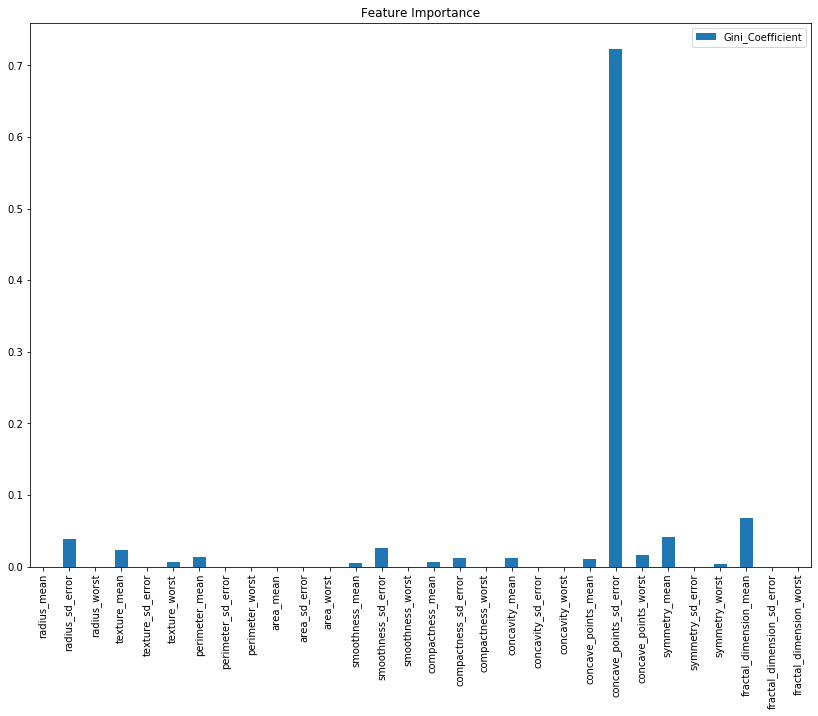

In [14]:
gini_df.plot(kind='bar', figsize=(14, 10), title='Feature Importance');

Based on the overlap between my earlier EDA (distribution plotting and t-tests, the logistic regression analysis, and the decision tree model, a few features stand out as being highly predictive of malignant tumors.

* concave_points_sd_error
* fractal_dimension_mean
* perimeter_sd_error


## Model Evaluation and Overfitting

Looking at the train and test accuracy, I can see that while this model performs comparably well to the Logistic Regression, the overfitting is apparent in the noticeable difference between train and test accuracy (even though the model still performs quite well on test data). On interpretability, I think this model surpasses Logistic Regression in that I can get a clear picture of feature importance. 

Below I will implement a couple of methods to correct for overfitting and produce the same more comprehensive output as I did for the regression. The most common methods of reducing variance in a Decision Tree model are forms of 'pruning,' which refers to limiting the the **depth** (the number of levels to the tree) or the number of **features** used in making criteria for node-splitting. In practice, a popular method is to build use ensemble methods such as creating a large number of simplistic, high-bias models, then averaging the results.

             precision    recall  f1-score   support

          0       0.93      0.92      0.92        72
          1       0.86      0.88      0.87        42

avg / total       0.90      0.90      0.90       114
 

ROC-AUC: 0.9222883597883598


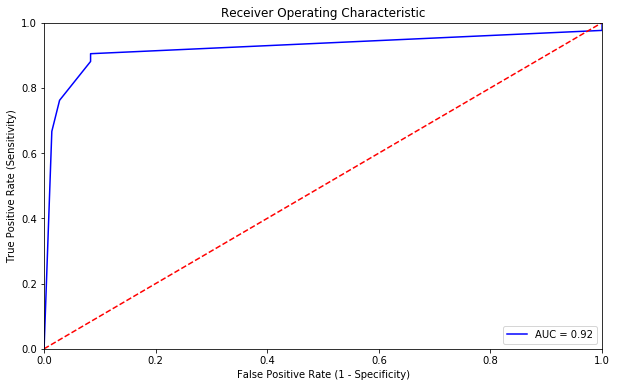

,Predicted Benign,Predicted Malignant
Actual Benign,66,6
Actual Malignant,5,37


In [15]:
# Single Decision Tree

# Setup gridsearch
grid_params = {
    'max_depth':[None, 1, 3, 5 ,7],
    'max_features':[None, 1, 2, 3, 4, 5]
}

# Instantiate model
dt = DecisionTreeClassifier()

gs = GridSearchCV(dt, grid_params, scoring = 'roc_auc', n_jobs = -1)
gs.fit(X_train, y_train)

# Run and evaluate model
model_dict, cm = get_classification_results(gs, 'Decision Tree (research)',
                                            X_train, X_test,
                                            y_train, y_test)

print_confusion_matrix(cm)

So based on a more comprehensive evaluation, taking into account measures other than accuracy, this model appears slightly worse than the Logistic Regression. However, it is still a very strong model and the actual metric that I would optimize for would have to depend on the relative cost of a Type I or Type II error. I imagine in the context of a medical diagnosis, a false negative would be more costly than a false positive, but I am not qualified to make that judgment without consulting an expert.

## Neural Net Approach

Because I have highlighted two of the most interpretable and intuitive models above, I wanted to explore the other end of the spectrum: the 'black box'-like approach of neural networks. Given the context - a medical diagnosis - it is likely that I care much more about getting the right answer than being able to explain _how_ the model works.

In this context, I won't be able to extract feature importance, and I am choosing not to dive too deeply into fine-tuning the model. I just want to see what a basic neural net can do with the same data.

In [16]:
# Split data into X and y
X = cancer.drop(columns='diagnosis')
y = cancer['diagnosis']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [17]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

input_units = X_train.shape[1]
hidden_units = input_units

model.add(Dense(hidden_units, input_dim=input_units, activation='relu'))
model.add(Dense(hidden_units*2, input_dim=input_units, activation='relu'))
model.add(Dense(hidden_units, input_dim=input_units, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 455 samples, validate on 114 samples
Epoch 1/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6105 - acc: 0.7582 - val_loss: 0.4552 - val_acc: 0.9211
Epoch 2/100
455/455 [==============================] - 0s 144us/step - loss: 0.3621 - acc: 0.9231 - val_loss: 0.2471 - val_acc: 0.9474
Epoch 3/100
455/455 [==============================] - 0s 124us/step - loss: 0.2101 - acc: 0.9363 - val_loss: 0.1509 - val_acc: 0.9474
Epoch 4/100
455/455 [==============================] - 0s 161us/step - loss: 0.1468 - acc: 0.9451 - val_loss: 0.1061 - val_acc: 0.9649
Epoch 5/100
455/455 [==============================] - 0s 148us/step - loss: 0.1126 - acc: 0.9560 - val_loss: 0.0833 - val_acc: 0.9825
Epoch 6/100
455/455 [==============================] - 0s 190us/step - loss: 0.0921 - acc: 0.9670 - val_loss: 0.0696 - val_acc: 0.9737
Epoch 7/100
455/455 [=====

In [18]:
history.history['acc'][-1]

1.0

A simple neural net with a basic structure and almost no fine tuning achieves produces a highly accurate model. This is only one simple example, and in this paricular case, the best Logistic Regression actually does quite well, but for the particular problem at hand, I would lean towards using the neural net if I had to choose, given the stakes at hand and my goal being more about getting the most reliable results rather than the most interpretable.

## Explanation

### For technical audiences

The models I created above performed quite well, but there are a several ways in which I could improve performance. First and foremost, with more time spent on EDA and background research, I can make improvements to feature selection and feature engineering. Above, I simply used every feature as is. There are two potential problems with such a tactic. One is multicollinearity: in addition to helping me find variables that would be good predictors, my earlier EDA (particularly my pairplots) show that several of the predictors are correlated with each other. For example, `radius_mean` and `radius_worst` appear to have a near-perfect linear relationship. This violates a basic assumption of regression analysis and suggests that using both features is unnecessary at best and problematic at worst. I could attempt to address this problem through some form of dimensionality reduction, either by dropping some variables or by implementing Principal Component Analysis. Another problem with my approach is that I did not explore interactions between variables, or polynomial features. Oftentimes two variables on their own are not useful predictors, but some combination of them may be. Or a feature can be squared (or cubed, etc.) to better represent its relationship with the target. 

Beyong feature engineering, there are some approaches I can take to improve my modeling. I only scratched the surface of hyperparameter tuning - I can explore a wider range of ridge and lasso penalties, or polynomial features (discussed above) in my logistic regression, and I can further try to optimize the `max_depth` and `max_features` parameters of my Decision Tree. Furthermore, there is no reason to stop at a single Decision Tree in my analysis. A better approach may be to Build an ensemble classifier from a variety of tree-based models (a voting classifier incorporating a number of high-bias models often does quite well and helps address the overfitting inherent in tree-based models). 

### For non-technical audiences

In the above analysis I attempt to predict whether a given tissue sample will be diagnosed as malignant breast cancer or benign - a **binary classification** problem. The features used to predict the outcome are measurements of cell characteristics and are all numeric (as in not categorical) values. Minimal preprocessing of data was required; the one necessary step was to convert my diagnosis vector to a binary outcome (1 for malignant, 0 for benign).

Before applying machine learning problems, I conducted some exploratory data analysis to get a feel for which variables were likely to be useful predictors of malignant diagnoses. A major component of this analysis involved comparing the distributions of each variable between malignant and benign samples, both visually and through statistical tests. From this analysis I expected `radius_mean`, `smoothness_mean`, `perimeter_mean`, `perimeter_sd_error`, and `concave_points_sd_error` to be strong predictors. As one example, it seems clear from both a visual representation and a t-test that the mean of `concave_points_sd_error` is higher in malignant observations than in benign observations.

After exploring the data, I moved on to making predictions using two commonly used (and relatively interpretable) machine learning models - **logistic regression** and **decision trees**. In a logistic regression, there is some mathematical nuance, but essentially the relationship between the independent variables and the _probability_ of observing a value of 1 in the dependent variable is assumed to be linear. So we are solving for the coefficients in a linear equation which represent the effect of each variable on the _odds_ of observing a particular binary outcome. The logistic regression, despite its simplicity, performed very well and had an accuracy above 90% (meaning 90% of predictions were correct) on both training and testing data (meaning the model performs similarly well on 'new' data as on the data it was fit to). In the logistic regression model, some features for which larger measurements _increased_ the probability of a malignant diagnosis were `area_sd_error`, `concave_points_worst`, and `concave_points_mean` and some features that _decreased_ the probability of a malignant diagnosis were `compactness_mean`, `area_worst`, and `concavity_sd_error`.

The decision tree is conceptually simpler than a logistic regression - it attempts to divide the dataset into subsamples based on some criteria (for example - split the dataset in two depending on whether a particular measurement is greater than or less than some threshold) - but can generate very complex models and can be helpful when trying to model non-linear relationships. The decisions about how to split the data into categories are made in such a way as to produce subsamples that are more 'pure' than the parent sample. For example: if you have a sample where 50% of observations are malignant and 50% are benign, you'd like to split based on some criteria such that you end up with one subsample that is 100% malignant and one that is 100% benign. While the resulting tree can be incredibly complex and can result in numerous decision points, the decision tree process provides information regarding which features it found most useful for categorizing the data. By this criterion - the most important features for predicting a malignant tumor were `concave_points_sd_error`, `fractal_dimension_mean`, `concave_points_mean`, and `symmetry_mean`. The decision tree model also performed quite well, but appeared to exhibit higher **variance** than the logistic regression, meaning that different inputs would result in very different models and that the resulting model performs noticeably worse on testing data than on training data.

Finally, I tested a simple neural network model, which performed exceptionally well but is much more of a 'black box' and therefore does not provide clear answers as to how it is making predictions or which features were more or less useful as predictors.